In [1]:
# General Imports
import math
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Ray Imports
from ray import tune
from ray.tune.registry import register_env
import ray.rllib.agents.ppo as ppo

# TT Imports
import tensortrade.env.default as default
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange,ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.instruments import Instrument
from tensortrade.oms.wallets import Portfolio

---

### DRL Model

### Train

Now in order to use our custom environment in ray we must first write a function that creates an instance of the TradingEnv from a configuration dictionary.

In [2]:
def create_training_env(config):
    """Creates Trading Environment. """
    
    # 1. Data and TensorTrade Objects
    # dataset = pd.read_csv('../../data/market/ohlcv_daily_TA/PETR3_train.csv')
    dataset = pd.read_csv('../../data/contextual_data_market_and_text/daily/PETR3_train.csv')
    
    # Price Series
    price = Stream.source(list(dataset["close"]), dtype="float").rename("BRL-ASSETS")
    
    b3_commission = 0.0035
    b3_options = ExchangeOptions(commission=b3_commission)
    b3_exchange = Exchange( name="B3", 
                            service=execute_order, 
                            options=b3_options)(price)
    
    # Instruments
    BRL = Instrument("BRL", 2, "Brazilian Currency")
    ASSETS = Instrument("ASSETS", 2, "Assets")

    # Portfolio
    cash = Wallet(b3_exchange, 100000 * BRL) # Money
    asset = Wallet(b3_exchange, 0 * ASSETS) # Stocks/Assets
    
    portfolio = Portfolio(BRL, [cash, asset])
    
    features = []
    for c in dataset.columns[1:]:
        s = Stream.source(list(dataset[c]), dtype="float").rename(dataset[c].name)
        features += [s]
    print (features)
    feed = DataFeed(features)
    feed.compile()
    
    # 2. Rewards

    # Rewards - Risk Adjusted Returns
    # reward_scheme = default.rewards.RiskAdjustedReturns(
    #     return_algorithm='sharpe',
    #     risk_free_rate=0,
    #     window_size= 7 * 5
    # )
    
    # Rewards - Simple Profit
    reward_scheme = default.rewards.SimpleProfit()
    
    # 3. Actions - Managed Risk Orders
    action_scheme = default.actions.ManagedRiskOrders(
        stop=[0.05],
        take=[0.075],
        min_order_pct=0.5
    )

    # 4. Visualization
    renderer_feed = DataFeed([
        Stream.source(list(dataset['date'])).rename("date"),
        Stream.source(list(dataset["open"]), dtype="float").rename("open"),
        Stream.source(list(dataset["high"]), dtype="float").rename("high"),
        Stream.source(list(dataset["low"]), dtype="float").rename("low"),
        Stream.source(list(dataset["close"]), dtype="float").rename("close"),
        Stream.source(list(dataset["volume"]), dtype="float").rename("volume")
    ])

    # 5. Environment
    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=default.renderers.PlotlyTradingChart(display=True, auto_open_html=False, save_format="png"),
        window_size=config["window_size"],
        max_allowed_loss=0.4
    )
    
    return environment

register_env("TradingEnv", create_training_env)

---

Now that the environment is registered we can run the training algorithm using the Proximal Policy Optimization (PPO) algorithm implemented in rllib.

In [3]:
window_size = 10

env_config_training = {
    # We want to look at the last N samples (days or hours)
    "window_size": window_size, # hours * days
    # And calculate reward based on the actions taken in the next 7 hours
    "reward_window_size": math.ceil(window_size / 2),
    # If it goes past 10% loss during the iteration, we don't want to waste time on a "loser".
    "max_allowed_loss": 0.15,
}

analysis = tune.run(
    run_or_experiment="PPO",
    name="MyExperiment",
    metric="episode_reward_mean",
    mode="max",
    stop={
      "training_iteration": 15
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": window_size
        },
        "log_level": "WARNING",
        "framework": "tf2",
        "eager_tracing": True,
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0.5,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },

    checkpoint_at_end=True
)

2022-06-16 13:12:40,695	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265


Trial name,status,loc
PPO_TradingEnv_2be59_00000,PENDING,


2022-06-16 13:12:51,695	ERROR syncer.py:111 -- Log sync requires rsync to be installed.
 pid=11556) 2022-06-16 13:12:57,639	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=True. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.


 pid=14420) [<tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C76130>, <tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C76280>, <tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C763D0>, <tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C76430>, <tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C76580>, <tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C766D0>, <tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C76820>, <tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C76970>, <tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C76AC0>, <tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C76C10>, <tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C76D60>, <tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C76EB0>, <tensortrade.feed.core.base.IterableStream object at 0x0000028CD8C76F70>, <tensortrade.feed.core.ba

Trial name,status,loc
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556


 pid=11556) 2022-06-16 13:13:06,801	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556


Trial name,status,loc
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556


Trial name,status,loc
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556


Trial name,status,loc
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556


Trial name,status,loc
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556


 pid=11556) 2022-06-16 13:13:28,710	WARNING deprecation.py:45 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
 pid=11556) 2022-06-16 13:13:28,714	WARNING deprecation.py:45 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556


Trial name,status,loc
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556


Trial name,status,loc
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-06-16_13-13-46
  done: false
  episode_len_mean: 288.2307692307692
  episode_media: {}
  episode_reward_max: 0.15045224193311357
  episode_reward_mean: -0.04039306665573107
  episode_reward_min: -0.47517695415073
  episodes_this_iter: 13
  episodes_total: 13
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.10000000149011612
          entropy: 3.043242931365967
          entropy_coeff: 0.009999999776482582
          kl: 0.0012467671185731888
          policy_loss: -0.0072500999085605145
          total_loss: 0.3974514603614807
          vf_explained_var: 0.03861121088266373
          vf_loss: 0.869769275188446
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  it

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,1,39.3359,4000,-0.0403931,0.150452,-0.475177,288.231


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,1,39.3359,4000,-0.0403931,0.150452,-0.475177,288.231


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,1,39.3359,4000,-0.0403931,0.150452,-0.475177,288.231


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,1,39.3359,4000,-0.0403931,0.150452,-0.475177,288.231


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,1,39.3359,4000,-0.0403931,0.150452,-0.475177,288.231


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,1,39.3359,4000,-0.0403931,0.150452,-0.475177,288.231


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,1,39.3359,4000,-0.0403931,0.150452,-0.475177,288.231


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,1,39.3359,4000,-0.0403931,0.150452,-0.475177,288.231


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-06-16_13-14-28
  done: false
  episode_len_mean: 288.81481481481484
  episode_media: {}
  episode_reward_max: 0.24432979580600356
  episode_reward_mean: -0.03255301175651258
  episode_reward_min: -0.47576144640128437
  episodes_this_iter: 14
  episodes_total: 27
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 0.000699999975040555
          entropy: 2.974083423614502
          entropy_coeff: 0.009999999776482582
          kl: 0.0649217888712883
          policy_loss: -0.12707509100437164
          total_loss: -0.018043097108602524
          vf_explained_var: 0.7069694995880127
          vf_loss: 0.2645612955093384
    num_agent_steps_sampled: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,2,81.3679,8000,-0.032553,0.24433,-0.475761,288.815


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,2,81.3679,8000,-0.032553,0.24433,-0.475761,288.815


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,2,81.3679,8000,-0.032553,0.24433,-0.475761,288.815


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,2,81.3679,8000,-0.032553,0.24433,-0.475761,288.815


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,2,81.3679,8000,-0.032553,0.24433,-0.475761,288.815


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,2,81.3679,8000,-0.032553,0.24433,-0.475761,288.815


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,2,81.3679,8000,-0.032553,0.24433,-0.475761,288.815


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,2,81.3679,8000,-0.032553,0.24433,-0.475761,288.815


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,2,81.3679,8000,-0.032553,0.24433,-0.475761,288.815


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-06-16_13-15-12
  done: false
  episode_len_mean: 292.6341463414634
  episode_media: {}
  episode_reward_max: 0.40832269621537454
  episode_reward_mean: 0.02093413356172821
  episode_reward_min: -0.47576144640128437
  episodes_this_iter: 14
  episodes_total: 41
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.15000000596046448
          cur_lr: 0.0003000000142492354
          entropy: 2.904709815979004
          entropy_coeff: 0.009999999776482582
          kl: 0.03945464640855789
          policy_loss: -0.13254527747631073
          total_loss: -0.06947671622037888
          vf_explained_var: 0.8256495594978333
          vf_loss: 0.17239494621753693
    num_agent_steps_sampled: 12000
    num_steps_sampled: 12000
    num_steps_trained: 120

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,3,125.606,12000,0.0209341,0.408323,-0.475761,292.634


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,3,125.606,12000,0.0209341,0.408323,-0.475761,292.634


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,3,125.606,12000,0.0209341,0.408323,-0.475761,292.634


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,3,125.606,12000,0.0209341,0.408323,-0.475761,292.634


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,3,125.606,12000,0.0209341,0.408323,-0.475761,292.634


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,3,125.606,12000,0.0209341,0.408323,-0.475761,292.634


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,3,125.606,12000,0.0209341,0.408323,-0.475761,292.634


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,3,125.606,12000,0.0209341,0.408323,-0.475761,292.634


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,3,125.606,12000,0.0209341,0.408323,-0.475761,292.634


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,3,125.606,12000,0.0209341,0.408323,-0.475761,292.634


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-06-16_13-16-02
  done: false
  episode_len_mean: 291.68518518518516
  episode_media: {}
  episode_reward_max: 0.40832269621537454
  episode_reward_mean: 0.04004476856181491
  episode_reward_min: -0.47623815880268605
  episodes_this_iter: 13
  episodes_total: 54
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.22499999403953552
          cur_lr: 9.7999996796716e-05
          entropy: 2.8628814220428467
          entropy_coeff: 0.009999999776482582
          kl: 0.021059226244688034
          policy_loss: -0.0981622040271759
          total_loss: -0.029034145176410675
          vf_explained_var: 0.8113833665847778
          vf_loss: 0.1860370934009552
    num_agent_steps_sampled: 16000
    num_steps_sampled: 16000
    num_steps_trained: 160

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,4,175.786,16000,0.0400448,0.408323,-0.476238,291.685


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,4,175.786,16000,0.0400448,0.408323,-0.476238,291.685


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,4,175.786,16000,0.0400448,0.408323,-0.476238,291.685


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,4,175.786,16000,0.0400448,0.408323,-0.476238,291.685


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,4,175.786,16000,0.0400448,0.408323,-0.476238,291.685


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,4,175.786,16000,0.0400448,0.408323,-0.476238,291.685


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,4,175.786,16000,0.0400448,0.408323,-0.476238,291.685


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,4,175.786,16000,0.0400448,0.408323,-0.476238,291.685


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,4,175.786,16000,0.0400448,0.408323,-0.476238,291.685


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2022-06-16_13-16-48
  done: false
  episode_len_mean: 293.3970588235294
  episode_media: {}
  episode_reward_max: 0.40832269621537454
  episode_reward_mean: 0.06217933381832575
  episode_reward_min: -0.47623815880268605
  episodes_this_iter: 14
  episodes_total: 68
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.3375000059604645
          cur_lr: 9.40000027185306e-05
          entropy: 2.8240411281585693
          entropy_coeff: 0.009999999776482582
          kl: 0.01829429157078266
          policy_loss: -0.09850172698497772
          total_loss: -0.03424929827451706
          vf_explained_var: 0.82686448097229
          vf_loss: 0.17263704538345337
    num_agent_steps_sampled: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,5,221.674,20000,0.0621793,0.408323,-0.476238,293.397


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,5,221.674,20000,0.0621793,0.408323,-0.476238,293.397


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,5,221.674,20000,0.0621793,0.408323,-0.476238,293.397


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,5,221.674,20000,0.0621793,0.408323,-0.476238,293.397


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,5,221.674,20000,0.0621793,0.408323,-0.476238,293.397


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,5,221.674,20000,0.0621793,0.408323,-0.476238,293.397


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,5,221.674,20000,0.0621793,0.408323,-0.476238,293.397


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,5,221.674,20000,0.0621793,0.408323,-0.476238,293.397


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2022-06-16_13-17-28
  done: false
  episode_len_mean: 294.4567901234568
  episode_media: {}
  episode_reward_max: 0.40832269621537454
  episode_reward_mean: 0.07290948159109419
  episode_reward_min: -0.47623815880268605
  episodes_this_iter: 13
  episodes_total: 81
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.3375000059604645
          cur_lr: 9.000000136438757e-05
          entropy: 2.7859461307525635
          entropy_coeff: 0.009999999776482582
          kl: 0.018334578722715378
          policy_loss: -0.09771324694156647
          total_loss: -0.0361020490527153
          vf_explained_var: 0.833901047706604
          vf_loss: 0.16656547784805298
    num_agent_steps_sampled: 24000
    num_steps_sampled: 24000
    num_steps_trained: 2400

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,6,261.783,24000,0.0729095,0.408323,-0.476238,294.457


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,6,261.783,24000,0.0729095,0.408323,-0.476238,294.457


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,6,261.783,24000,0.0729095,0.408323,-0.476238,294.457


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,6,261.783,24000,0.0729095,0.408323,-0.476238,294.457


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,6,261.783,24000,0.0729095,0.408323,-0.476238,294.457


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,6,261.783,24000,0.0729095,0.408323,-0.476238,294.457


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,6,261.783,24000,0.0729095,0.408323,-0.476238,294.457


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,6,261.783,24000,0.0729095,0.408323,-0.476238,294.457


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,6,261.783,24000,0.0729095,0.408323,-0.476238,294.457


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2022-06-16_13-18-15
  done: false
  episode_len_mean: 295.22340425531917
  episode_media: {}
  episode_reward_max: 0.5768389977212942
  episode_reward_mean: 0.09215458443673488
  episode_reward_min: -0.47623815880268605
  episodes_this_iter: 13
  episodes_total: 94
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.3375000059604645
          cur_lr: 8.600000001024455e-05
          entropy: 2.734245777130127
          entropy_coeff: 0.009999999776482582
          kl: 0.01931922882795334
          policy_loss: -0.09617606550455093
          total_loss: -0.02934589795768261
          vf_explained_var: 0.8241099715232849
          vf_loss: 0.17530480027198792
    num_agent_steps_sampled: 28000
    num_steps_sampled: 28000
    num_steps_trained: 2800

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,7,308.369,28000,0.0921546,0.576839,-0.476238,295.223


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,7,308.369,28000,0.0921546,0.576839,-0.476238,295.223


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,7,308.369,28000,0.0921546,0.576839,-0.476238,295.223


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,7,308.369,28000,0.0921546,0.576839,-0.476238,295.223


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,7,308.369,28000,0.0921546,0.576839,-0.476238,295.223


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,7,308.369,28000,0.0921546,0.576839,-0.476238,295.223


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,7,308.369,28000,0.0921546,0.576839,-0.476238,295.223


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,7,308.369,28000,0.0921546,0.576839,-0.476238,295.223


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2022-06-16_13-18-58
  done: false
  episode_len_mean: 295.51
  episode_media: {}
  episode_reward_max: 0.6007229883371037
  episode_reward_mean: 0.12275949114636792
  episode_reward_min: -0.47623815880268605
  episodes_this_iter: 14
  episodes_total: 108
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.3375000059604645
          cur_lr: 8.199999865610152e-05
          entropy: 2.6890599727630615
          entropy_coeff: 0.009999999776482582
          kl: 0.017205707728862762
          policy_loss: -0.08561984449625015
          total_loss: -0.035344455391168594
          vf_explained_var: 0.8591264486312866
          vf_loss: 0.1427181363105774
    num_agent_steps_sampled: 32000
    num_steps_sampled: 32000
    num_steps_trained: 32000
    num

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,8,351.457,32000,0.122759,0.600723,-0.476238,295.51


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,8,351.457,32000,0.122759,0.600723,-0.476238,295.51


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,8,351.457,32000,0.122759,0.600723,-0.476238,295.51


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,8,351.457,32000,0.122759,0.600723,-0.476238,295.51


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,8,351.457,32000,0.122759,0.600723,-0.476238,295.51


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,8,351.457,32000,0.122759,0.600723,-0.476238,295.51


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,8,351.457,32000,0.122759,0.600723,-0.476238,295.51


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,8,351.457,32000,0.122759,0.600723,-0.476238,295.51


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2022-06-16_13-19-40
  done: false
  episode_len_mean: 297.04
  episode_media: {}
  episode_reward_max: 0.6007229883371037
  episode_reward_mean: 0.15539272072758512
  episode_reward_min: -0.47623815880268605
  episodes_this_iter: 13
  episodes_total: 121
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.3375000059604645
          cur_lr: 7.79999973019585e-05
          entropy: 2.6431736946105957
          entropy_coeff: 0.009999999776482582
          kl: 0.017586620524525642
          policy_loss: -0.08272314071655273
          total_loss: -0.03444316238164902
          vf_explained_var: 0.8680180907249451
          vf_loss: 0.13755248486995697
    num_agent_steps_sampled: 36000
    num_steps_sampled: 36000
    num_steps_trained: 36000
    num_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,9,393.295,36000,0.155393,0.600723,-0.476238,297.04


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,9,393.295,36000,0.155393,0.600723,-0.476238,297.04


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,9,393.295,36000,0.155393,0.600723,-0.476238,297.04


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,9,393.295,36000,0.155393,0.600723,-0.476238,297.04


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,9,393.295,36000,0.155393,0.600723,-0.476238,297.04


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,9,393.295,36000,0.155393,0.600723,-0.476238,297.04


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,9,393.295,36000,0.155393,0.600723,-0.476238,297.04


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,9,393.295,36000,0.155393,0.600723,-0.476238,297.04


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2022-06-16_13-20-20
  done: false
  episode_len_mean: 298.53
  episode_media: {}
  episode_reward_max: 0.6007229883371037
  episode_reward_mean: 0.1759145277763301
  episode_reward_min: -0.47623815880268605
  episodes_this_iter: 13
  episodes_total: 134
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.3375000059604645
          cur_lr: 7.400000322377309e-05
          entropy: 2.6050240993499756
          entropy_coeff: 0.009999999776482582
          kl: 0.01505268644541502
          policy_loss: -0.071004219353199
          total_loss: -0.03261343389749527
          vf_explained_var: 0.8849995136260986
          vf_loss: 0.11872149258852005
    num_agent_steps_sampled: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
    num_ste

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,10,433.431,40000,0.175915,0.600723,-0.476238,298.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,10,433.431,40000,0.175915,0.600723,-0.476238,298.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,10,433.431,40000,0.175915,0.600723,-0.476238,298.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,10,433.431,40000,0.175915,0.600723,-0.476238,298.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,10,433.431,40000,0.175915,0.600723,-0.476238,298.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,10,433.431,40000,0.175915,0.600723,-0.476238,298.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,10,433.431,40000,0.175915,0.600723,-0.476238,298.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,10,433.431,40000,0.175915,0.600723,-0.476238,298.53


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 44000
  custom_metrics: {}
  date: 2022-06-16_13-20-59
  done: false
  episode_len_mean: 300.0
  episode_media: {}
  episode_reward_max: 0.6007229883371037
  episode_reward_mean: 0.20216355628541222
  episode_reward_min: -0.1642089598077986
  episodes_this_iter: 14
  episodes_total: 148
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.3375000059604645
          cur_lr: 7.000000186963007e-05
          entropy: 2.5730111598968506
          entropy_coeff: 0.009999999776482582
          kl: 0.01659144088625908
          policy_loss: -0.0793415829539299
          total_loss: -0.044278014451265335
          vf_explained_var: 0.8946102261543274
          vf_loss: 0.1103881448507309
    num_agent_steps_sampled: 44000
    num_steps_sampled: 44000
    num_steps_trained: 44000
    num_ste

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,11,472.739,44000,0.202164,0.600723,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,11,472.739,44000,0.202164,0.600723,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,11,472.739,44000,0.202164,0.600723,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,11,472.739,44000,0.202164,0.600723,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,11,472.739,44000,0.202164,0.600723,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,11,472.739,44000,0.202164,0.600723,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,11,472.739,44000,0.202164,0.600723,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,11,472.739,44000,0.202164,0.600723,-0.164209,300


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 48000
  custom_metrics: {}
  date: 2022-06-16_13-21-41
  done: false
  episode_len_mean: 300.0
  episode_media: {}
  episode_reward_max: 0.6192879220888272
  episode_reward_mean: 0.21922921893797767
  episode_reward_min: -0.1642089598077986
  episodes_this_iter: 13
  episodes_total: 161
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.3375000059604645
          cur_lr: 6.600000051548705e-05
          entropy: 2.5392887592315674
          entropy_coeff: 0.009999999776482582
          kl: 0.01491283718496561
          policy_loss: -0.07244320958852768
          total_loss: -0.039894022047519684
          vf_explained_var: 0.8993951678276062
          vf_loss: 0.10581798851490021
    num_agent_steps_sampled: 48000
    num_steps_sampled: 48000
    num_steps_trained: 48000
    num_s

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,12,513.828,48000,0.219229,0.619288,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,12,513.828,48000,0.219229,0.619288,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,12,513.828,48000,0.219229,0.619288,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,12,513.828,48000,0.219229,0.619288,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,12,513.828,48000,0.219229,0.619288,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,12,513.828,48000,0.219229,0.619288,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,12,513.828,48000,0.219229,0.619288,-0.164209,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,12,513.828,48000,0.219229,0.619288,-0.164209,300


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 52000
  custom_metrics: {}
  date: 2022-06-16_13-22-21
  done: false
  episode_len_mean: 300.0
  episode_media: {}
  episode_reward_max: 0.6241443762793663
  episode_reward_mean: 0.24557659836265214
  episode_reward_min: -0.07051431292363575
  episodes_this_iter: 13
  episodes_total: 174
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.3375000059604645
          cur_lr: 6.199999916134402e-05
          entropy: 2.5178701877593994
          entropy_coeff: 0.009999999776482582
          kl: 0.014181136153638363
          policy_loss: -0.06630861014127731
          total_loss: -0.04094213619828224
          vf_explained_var: 0.9139160513877869
          vf_loss: 0.09151808172464371
    num_agent_steps_sampled: 52000
    num_steps_sampled: 52000
    num_steps_trained: 52000
    num_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,13,554.657,52000,0.245577,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,13,554.657,52000,0.245577,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,13,554.657,52000,0.245577,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,13,554.657,52000,0.245577,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,13,554.657,52000,0.245577,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,13,554.657,52000,0.245577,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,13,554.657,52000,0.245577,0.624144,-0.0705143,300


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 56000
  custom_metrics: {}
  date: 2022-06-16_13-23-02
  done: false
  episode_len_mean: 300.0
  episode_media: {}
  episode_reward_max: 0.6241443762793663
  episode_reward_mean: 0.26788637310746055
  episode_reward_min: -0.07051431292363575
  episodes_this_iter: 14
  episodes_total: 188
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.3375000059604645
          cur_lr: 5.8000001445179805e-05
          entropy: 2.505580186843872
          entropy_coeff: 0.009999999776482582
          kl: 0.013168525882065296
          policy_loss: -0.06436460465192795
          total_loss: -0.041475240141153336
          vf_explained_var: 0.9179748296737671
          vf_loss: 0.08700156211853027
    num_agent_steps_sampled: 56000
    num_steps_sampled: 56000
    num_steps_trained: 56000
    num

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,14,595.022,56000,0.267886,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,14,595.022,56000,0.267886,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,14,595.022,56000,0.267886,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,14,595.022,56000,0.267886,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,14,595.022,56000,0.267886,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,14,595.022,56000,0.267886,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,14,595.022,56000,0.267886,0.624144,-0.0705143,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,14,595.022,56000,0.267886,0.624144,-0.0705143,300


Result for PPO_TradingEnv_2be59_00000:
  agent_timesteps_total: 60000
  custom_metrics: {}
  date: 2022-06-16_13-23-42
  done: true
  episode_len_mean: 300.0
  episode_media: {}
  episode_reward_max: 0.6241443762793663
  episode_reward_mean: 0.2917019785489767
  episode_reward_min: 0.021231532167796052
  episodes_this_iter: 13
  episodes_total: 201
  experiment_id: 178acfdf5b124ca681fafdb303ec0e9c
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.3375000059604645
          cur_lr: 5.400000009103678e-05
          entropy: 2.475982666015625
          entropy_coeff: 0.009999999776482582
          kl: 0.014029279351234436
          policy_loss: -0.06633847206830978
          total_loss: -0.04897105693817139
          vf_explained_var: 0.9289526343345642
          vf_loss: 0.07478472590446472
    num_agent_steps_sampled: 60000
    num_steps_sampled: 60000
    num_steps_trained: 60000
    num_ste

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,RUNNING,127.0.0.1:11556,15,635.011,60000,0.291702,0.624144,0.0212315,300


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_2be59_00000,TERMINATED,127.0.0.1:11556,15,635.011,60000,0.291702,0.624144,0.0212315,300


2022-06-16 13:23:45,513	INFO tune.py:626 -- Total run time: 654.10 seconds (653.34 seconds for the tuning loop).


---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

In [4]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean", mode="max"),
    metric="episode_reward_mean"    
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": window_size # We want to look at the last x samples (days)
        },
        "framework": "tf2",
        "eager_tracing": False,
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0.5,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)

agent.restore(checkpoint_path)

2022-06-16 13:23:45,847	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.


 pid=15404) [<tensortrade.feed.core.base.IterableStream object at 0x0000024BC9214190>, <tensortrade.feed.core.base.IterableStream object at 0x0000024BC92142E0>, <tensortrade.feed.core.base.IterableStream object at 0x0000024BC9214430>, <tensortrade.feed.core.base.IterableStream object at 0x0000024BC9214490>, <tensortrade.feed.core.base.IterableStream object at 0x0000024BC92145E0>, <tensortrade.feed.core.base.IterableStream object at 0x0000024BC9214730>, <tensortrade.feed.core.base.IterableStream object at 0x0000024BC9214880>, <tensortrade.feed.core.base.IterableStream object at 0x0000024BC92149D0>, <tensortrade.feed.core.base.IterableStream object at 0x0000024BC9214B20>, <tensortrade.feed.core.base.IterableStream object at 0x0000024BC9214C70>, <tensortrade.feed.core.base.IterableStream object at 0x0000024BC9214DC0>, <tensortrade.feed.core.base.IterableStream object at 0x0000024BC9214F10>, <tensortrade.feed.core.base.IterableStream object at 0x0000024BC9214FD0>, <tensortrade.feed.core.ba

 pid=15404) 2022-06-16 13:24:21,675	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
 pid=15404) 2022-06-16 13:24:21,805	DEBUG rollout_worker.py:1534 -- Creating policy for default_policy
 pid=15404) 2022-06-16 13:24:21,814	DEBUG catalog.py:706 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x0000024BC9264700>: Box([[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 pid=15404)   -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=15404)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 pid=15404)   -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=15404)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 pid=15404)   -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=15404)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 pid=15404)   -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=15404)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -in

---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

In [5]:
# Restore agent
agent.restore(checkpoint_path)

# Instantiate the environment
env = create_training_env({
    "window_size": window_size
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

2022-06-16 13:24:27,543	INFO trainable.py:467 -- Restored on 127.0.0.1 from checkpoint: C:\Users\mathe\ray_results\MyExperiment\PPO_TradingEnv_2be59_00000_0_2022-06-16_13-12-51\checkpoint_000015\checkpoint-15
2022-06-16 13:24:27,544	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 15, '_timesteps_total': 0, '_time_total': 635.0113184452057, '_episodes_total': 201}


[<tensortrade.feed.core.base.IterableStream object at 0x00000211BBF16130>, <tensortrade.feed.core.base.IterableStream object at 0x00000211BEAA6E80>, <tensortrade.feed.core.base.IterableStream object at 0x00000211C50212E0>, <tensortrade.feed.core.base.IterableStream object at 0x00000211C5021250>, <tensortrade.feed.core.base.IterableStream object at 0x00000211C50219D0>, <tensortrade.feed.core.base.IterableStream object at 0x00000211C5021A60>, <tensortrade.feed.core.base.IterableStream object at 0x00000211C5021760>, <tensortrade.feed.core.base.IterableStream object at 0x00000211C5021B80>, <tensortrade.feed.core.base.IterableStream object at 0x00000211C5021430>, <tensortrade.feed.core.base.IterableStream object at 0x00000211C5021D30>, <tensortrade.feed.core.base.IterableStream object at 0x00000211BEA64C40>, <tensortrade.feed.core.base.IterableStream object at 0x00000211BEA646A0>, <tensortrade.feed.core.base.IterableStream object at 0x00000211BEA9E940>, <tensortrade.feed.core.base.IterableS

FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

---

### Validation Set

In [6]:
def create_eval_env(config):
    """Creates the Evaluation Environment."""
    #dataset = pd.read_csv('../../data/market/ohlcv_daily_TA/PETR3_test.csv')
    dataset = pd.read_csv('../../data/contextual_data_market_and_text/daily/PETR3_test.csv')

    # Price Series
    price = Stream.source(list(dataset["close"]), dtype="float").rename("BRL-ASSETS")
    
    b3_commission = 0.0035
    b3_options = ExchangeOptions(commission=b3_commission)
    b3_exchange = Exchange("B3", service=execute_order, options=b3_options)(price)
    
    # Instruments
    BRL = Instrument("BRL", 2, "Brazilian Currency")
    ASSETS = Instrument("ASSETS", 2, "Assets")

    # Portfolio
    cash = Wallet(b3_exchange, 100000 * BRL) # Money
    asset = Wallet(b3_exchange, 0 * ASSETS) # Stocks/Assets
    
    portfolio = Portfolio(BRL, [cash, asset])
    
    features = []
    for c in dataset.columns[1:]:
        s = Stream.source(list(dataset[c]), dtype="float").rename(dataset[c].name)
        features += [s]
    print (features)
    feed = DataFeed(features)
    feed.compile()
    
    # Rewards - Risk Adjusted Returns
    # reward_scheme = default.rewards.RiskAdjustedReturns(
    #     return_algorithm='sharpe',
    #     risk_free_rate=0,
    #     window_size= 7 * 5
    # )

    # Rewards - Simple Profit
    reward_scheme = default.rewards.RiskAdjustedReturns()#SimpleProfit()
    
    # Actions
    action_scheme = default.actions.ManagedRiskOrders(
        stop=[0.05],
        take=[0.075],
        min_order_pct=0.5
    )

    # A discrete action scheme that determines actions based on managing risk
    # action_scheme = default.actions.ManagedRiskOrders()
    
    # Visualization
    renderer_feed = DataFeed([
        Stream.source(list(dataset['date'])).rename("date"),
        Stream.source(list(dataset["open"]), dtype="float").rename("open"),
        Stream.source(list(dataset["high"]), dtype="float").rename("high"),
        Stream.source(list(dataset["low"]), dtype="float").rename("low"),
        Stream.source(list(dataset["close"]), dtype="float").rename("close"),
        Stream.source(list(dataset["volume"]), dtype="float").rename("volume")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=default.renderers.PlotlyTradingChart(display=True, auto_open_html=False, save_format="png"),
        window_size=config["window_size"],
        max_allowed_loss=0.4
    )
    
    return environment, portfolio

In [7]:
# 1. Instantiate the evaluation environment
env, portfolio = create_eval_env({
    "window_size": window_size
})

# 2. Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    
env.render()

portfolio.ledger.as_frame().head(10)

[<tensortrade.feed.core.base.IterableStream object at 0x000002137F43D820>, <tensortrade.feed.core.base.IterableStream object at 0x000002137F43D970>, <tensortrade.feed.core.base.IterableStream object at 0x00000213807F9190>, <tensortrade.feed.core.base.IterableStream object at 0x00000213807F92E0>, <tensortrade.feed.core.base.IterableStream object at 0x00000213807F95E0>, <tensortrade.feed.core.base.IterableStream object at 0x00000213807F9160>, <tensortrade.feed.core.base.IterableStream object at 0x00000213807F9CA0>, <tensortrade.feed.core.base.IterableStream object at 0x00000213807F9A30>, <tensortrade.feed.core.base.IterableStream object at 0x00000213807F9B50>, <tensortrade.feed.core.base.IterableStream object at 0x00000213807F98B0>, <tensortrade.feed.core.base.IterableStream object at 0x00000213807F9910>, <tensortrade.feed.core.base.IterableStream object at 0x00000213807F9730>, <tensortrade.feed.core.base.IterableStream object at 0x00000213807F9C40>, <tensortrade.feed.core.base.IterableS

FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,25e9708e-014e-41bc-8f9f-8572224fbeb7,2,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),80000.00 BRL,20000.00 BRL,80000.00 BRL,80000.00 BRL
1,25e9708e-014e-41bc-8f9f-8572224fbeb7,2,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),280.00 BRL,20000.00 BRL,79720.00 BRL,79720.00 BRL
2,25e9708e-014e-41bc-8f9f-8572224fbeb7,2,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),79720.00 BRL,20000.00 BRL,0.00 BRL,0.00 BRL
3,25e9708e-014e-41bc-8f9f-8572224fbeb7,2,B3,B3:ASSETS/locked,DEPOSIT (TRADED 79720.00 BRL B3:BRL/ASSETS @ 2...,3301.04 ASSETS,0.00 ASSETS,3301.04 ASSETS,3301.04 ASSETS
4,25e9708e-014e-41bc-8f9f-8572224fbeb7,13,B3:ASSETS/locked,B3,WITHDRAWAL (COMMISSION),11.55 ASSETS,0.00 ASSETS,3289.49 ASSETS,3289.49 ASSETS
5,25e9708e-014e-41bc-8f9f-8572224fbeb7,13,B3:ASSETS/locked,B3,WITHDRAWAL (FILL ORDER),3289.49 ASSETS,0.00 ASSETS,0.00 ASSETS,0.00 ASSETS
6,25e9708e-014e-41bc-8f9f-8572224fbeb7,13,B3,B3:BRL/locked,DEPOSIT (TRADED 3289.49 ASSETS B3:BRL/ASSETS @...,73849.05 BRL,20000.00 BRL,73849.05 BRL,73849.05 BRL
7,25e9708e-014e-41bc-8f9f-8572224fbeb7,13,B3:BRL/locked,B3:BRL/free,UNLOCK BRL (COMPLETED),73849.05 BRL,93849.05 BRL,0.00 BRL,0.00 BRL
8,25e9708e-014e-41bc-8f9f-8572224fbeb7,13,B3:ASSETS/locked,B3:ASSETS/free,UNLOCK ASSETS (COMPLETED),0.00 ASSETS,0.00 ASSETS,0.00 ASSETS,0.00 ASSETS
9,5adbc8d0-8821-406f-be9b-1a3b538feca7,15,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),84464.15 BRL,9384.90 BRL,84464.15 BRL,84464.15 BRL


In [8]:
portfolio.ledger.as_frame().head(10)

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,25e9708e-014e-41bc-8f9f-8572224fbeb7,2,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),80000.00 BRL,20000.00 BRL,80000.00 BRL,80000.00 BRL
1,25e9708e-014e-41bc-8f9f-8572224fbeb7,2,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),280.00 BRL,20000.00 BRL,79720.00 BRL,79720.00 BRL
2,25e9708e-014e-41bc-8f9f-8572224fbeb7,2,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),79720.00 BRL,20000.00 BRL,0.00 BRL,0.00 BRL
3,25e9708e-014e-41bc-8f9f-8572224fbeb7,2,B3,B3:ASSETS/locked,DEPOSIT (TRADED 79720.00 BRL B3:BRL/ASSETS @ 2...,3301.04 ASSETS,0.00 ASSETS,3301.04 ASSETS,3301.04 ASSETS
4,25e9708e-014e-41bc-8f9f-8572224fbeb7,13,B3:ASSETS/locked,B3,WITHDRAWAL (COMMISSION),11.55 ASSETS,0.00 ASSETS,3289.49 ASSETS,3289.49 ASSETS
5,25e9708e-014e-41bc-8f9f-8572224fbeb7,13,B3:ASSETS/locked,B3,WITHDRAWAL (FILL ORDER),3289.49 ASSETS,0.00 ASSETS,0.00 ASSETS,0.00 ASSETS
6,25e9708e-014e-41bc-8f9f-8572224fbeb7,13,B3,B3:BRL/locked,DEPOSIT (TRADED 3289.49 ASSETS B3:BRL/ASSETS @...,73849.05 BRL,20000.00 BRL,73849.05 BRL,73849.05 BRL
7,25e9708e-014e-41bc-8f9f-8572224fbeb7,13,B3:BRL/locked,B3:BRL/free,UNLOCK BRL (COMPLETED),73849.05 BRL,93849.05 BRL,0.00 BRL,0.00 BRL
8,25e9708e-014e-41bc-8f9f-8572224fbeb7,13,B3:ASSETS/locked,B3:ASSETS/free,UNLOCK ASSETS (COMPLETED),0.00 ASSETS,0.00 ASSETS,0.00 ASSETS,0.00 ASSETS
9,5adbc8d0-8821-406f-be9b-1a3b538feca7,15,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),84464.15 BRL,9384.90 BRL,84464.15 BRL,84464.15 BRL


In [9]:
df = pd.DataFrame(portfolio.performance)

<AxesSubplot:>

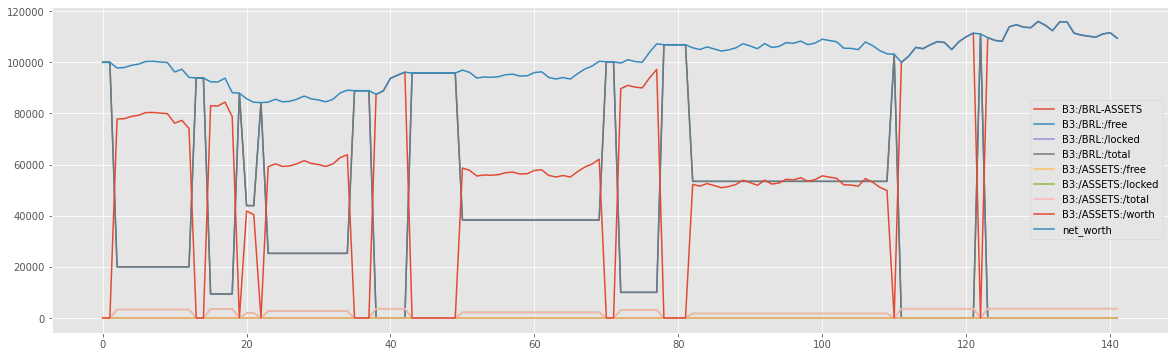

In [10]:
df.T.plot(figsize=(20,6))

<AxesSubplot:>

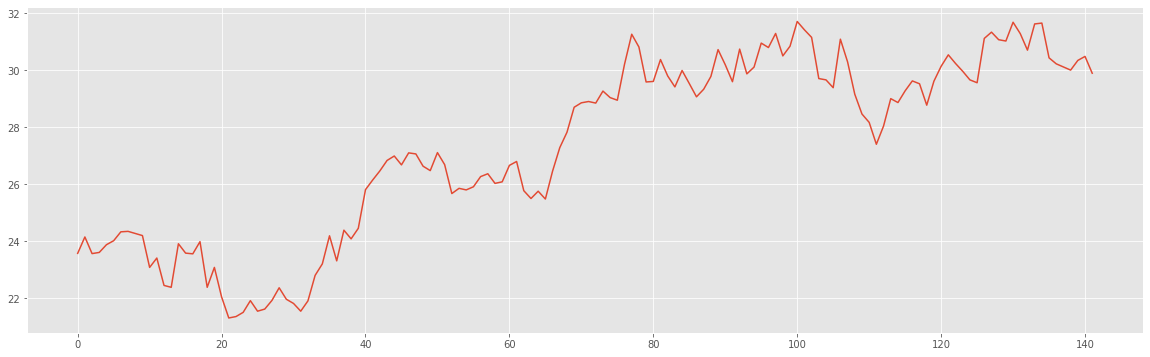

In [11]:
df.loc["B3:/BRL-ASSETS"].plot(figsize=(20,6))

<AxesSubplot:>

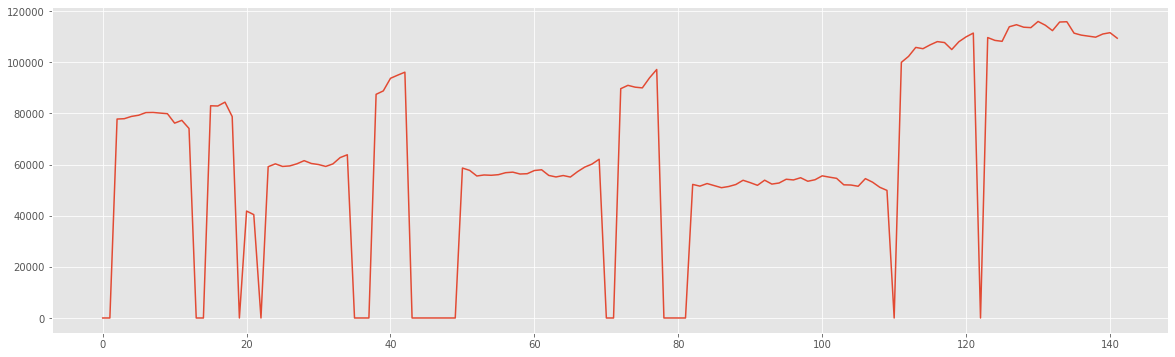

In [12]:
df.loc["B3:/ASSETS:/worth"].plot(figsize=(20,6))

---

### Net Worth Analysis (with Quantstats)

In [13]:
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

In [14]:
#dataset = pd.read_csv('../../data/market/ohlcv_daily_TA/PETR3_test.csv')
dataset = pd.read_csv('../../data/contextual_data_market_and_text/daily/PETR3_test.csv')

net_worth = df.loc["net_worth"].rename('close')
net_worth.index = dataset['date'].loc[:]
net_worth.index = pd.to_datetime(net_worth.index)

net_worth = net_worth.resample('D').last()
net_worth.index = net_worth.index.date
net_worth.index = net_worth.index.rename('date')

In [15]:
net_returns = net_worth.pct_change().dropna()
net_returns.index = pd.to_datetime(net_returns.index)
net_returns

date
2021-10-05    0.000000
2021-10-06   -0.021940
2021-10-07    0.001386
2021-10-08    0.009138
2021-10-09    0.000000
                ...   
2022-04-28    0.011330
2022-04-29    0.004613
2022-04-30    0.000000
2022-05-01    0.000000
2022-05-02   -0.019351
Name: close, Length: 210, dtype: float64

In [16]:
# show sharpe ratio
qs.stats.sharpe(net_returns)

0.6201583117993112

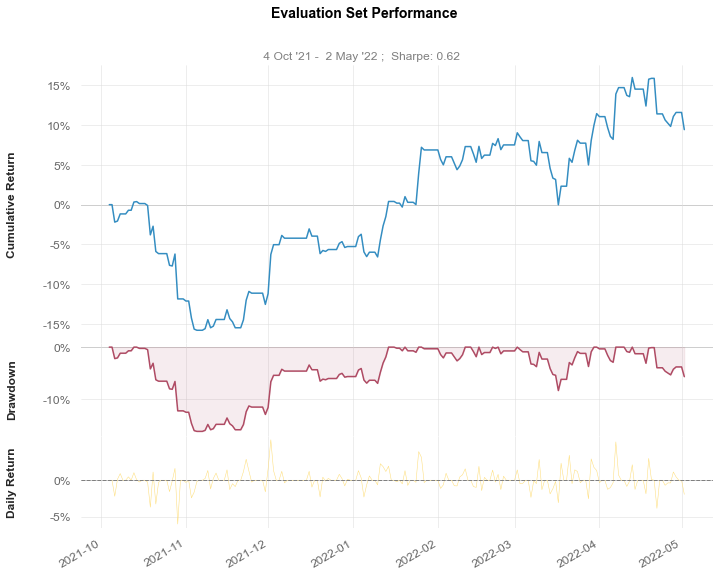

In [17]:
# Show overall performance
qs.plots.snapshot(net_returns, title=f'Evaluation Set Performance')

In [18]:
# Convert datetime to date (keep end of day result)
qs.reports.html(net_returns, "^BVSP")

---